**hERG - QSAR**

We are going to perform a **Leave-Cluster-Out-Cross-Validation** to estimate the performance of the machine learning algorithm when they are used to make predictions.

This is a cross-validation procedure, leave-cluster-out cross-validation (LCOCV), in which for each cluster, the data set is partitioned in such a way that the model on which any given instance is tested has been trained on data that excludes all members of the same cluster, and thereafter model performance is averaged across the considered training/test partitions.

Indeed, the ultimate goal of a validation strategy is to simulate with sufficient accuracy the difficulties that one would encounter when applying a methodology in a real-world scenario.

This method offers the following advantages : 

- It provides a much less biased measure of test MSE compared to using a single test set because we repeatedly fit a model to a data set that contains *n-1* observations.
- It tends not to overestimate the test MSE compared to using a single test set.

However, leave-cluster-out cross-validation comes with the following cons:

- It can be a time-consuming process to use when *n* is large.
- It can also be time-consuming if a model is particularly complex and takes a long time to fit to a data set.
- It can be computationally expensive.



----------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 1 : Import the libraries** 

In [184]:
import pandas as pd                     # 'panel data' makes easy to manipulate data
import numpy as np                      # to allow to generate random  numbers 

import matplotlib.pyplot as plt                # to draw graphs
import seaborn as sns                          # ...
import plotly.express as px                    # ...

from sklearn.decomposition import PCA                                 # to import the PCA function from sklearn
from sklearn.preprocessing import StandardScaler                      # to perform preprocessing part


import umap                                                           # to perform UMAP 
import umap.plot                                                      # to project UMAP 

from __future__ import print_function                                # to perform the MaxMin algorithm for the diversity selection 
from rdkit import Chem                                               # ... and to import rdkit packages
from rdkit.Chem import Draw,rdMolDescriptors,AllChem                 # ...
from rdkit.Chem.Draw import IPythonConsole                           # ...
from rdkit import SimDivFilters,DataStructs                          # ...
from rdkit import rdBase                                             # ...

from operator import index                                           # to use index row


**Step 2 : Import data** 

In [185]:
df = pd.read_csv('hERG_data_with_features.csv')                       # to download the data from the file into a dataframe called df
df.head()                                                             # to view the top 5 rows 


,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Compound_name,Standard Relation,IC50_nM,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,21,'=',20700.0,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,23e,'>',10000.0,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,26,'=',650.0,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,9j,'=',2110.0,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,11,'>',100000.0,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN


In [186]:
df.shape

(6824, 26)

In [187]:
data = df.to_numpy()    # to convert the Pandas Dataframe to a Numpyarray ; useful when using the functions of the hdbscan package

**Step 3 : Display the summary statistic for independant variables**

In [188]:
df.iloc[2:].describe()

,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,HeavyAtomCount,NumAliphaticCarbocycles,NumAromaticCarbocycles,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumAromaticRings,IC50_nM,Outcome,pIC50
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6.822000e+03,6822.000000,5107.000000
mean,438.682620,0.564816,1.846893,76.268464,5.586338,1.279683,3.835777,0.386285,5.678687,31.257696,0.311785,1.423923,1.224568,1.365435,2.789358,1.118773e+06,0.496629,5.410024
std,85.766944,0.186802,0.204419,31.038041,2.135583,1.084494,1.344421,0.151844,2.275604,6.136322,0.569445,0.795643,0.890580,1.080675,1.034963,2.853587e+07,0.500025,0.940475
min,94.053098,0.030383,0.722222,0.000000,0.000000,0.000000,-4.258600,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e-01,0.000000,0.020000
25%,381.144995,0.427815,1.735294,55.560000,4.000000,0.000000,2.934675,0.291667,4.000000,27.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.340000e+03,0.000000,4.823909
50%,437.170280,0.561591,1.868421,76.040000,5.000000,1.000000,3.774850,0.384615,6.000000,31.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000e+04,0.000000,5.270835
75%,492.192593,0.709095,2.000000,96.250000,7.000000,2.000000,4.650200,0.478261,7.000000,35.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.983000e+04,1.000000,5.823909
max,1241.713207,0.947494,2.611111,463.290000,19.000000,16.000000,9.839080,1.000000,32.000000,88.000000,6.000000,5.000000,5.000000,5.000000,7.000000,1.000000e+09,1.000000,9.853872


In [189]:
# to plot only the selected descriptors and compare with the clusters
descr_dict={}                                     
for idx, name in enumerate(df.columns):
    descr_dict[name] = idx
print(descr_dict)

{'SMILES_new': 0, 'ExactMolWt': 1, 'qed': 2, 'FpDensityMorgan2': 3, 'TPSA': 4, 'NumHAcceptors': 5, 'NumHDonors': 6, 'MolLogP': 7, 'FractionCSP3': 8, 'NumRotatableBonds': 9, 'HeavyAtomCount': 10, 'NumAliphaticCarbocycles': 11, 'NumAromaticCarbocycles': 12, 'NumAliphaticHeterocycles': 13, 'NumAromaticHeterocycles': 14, 'NumAromaticRings': 15, 'Compound_name': 16, 'Standard Relation': 17, 'IC50_nM': 18, 'Outcome': 19, 'pIC50': 20, 'InChIKey': 21, 'desalted\\demetalled': 22, 'mixture': 23, 'complex': 24, 'changes': 25}


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Part 1 : Principal Component Analysis (PCA) for Visualization**

PCA is an unsupervised learning method usefull to visualize multidimensional data by reducing the dimensionality of data sets, increasing interpretability but at the same time minimizing information loss. It also means less computation or training time. 

**Step 1 : Standardize the data**

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [190]:

#features = ['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']
#X = df.loc[:, features].values

#Y = df.loc[:,['Outcome']].values

# to separate the features and the outcome

In [191]:
#X = StandardScaler().fit_transform(X)                 # to standardize the features 
#pd.DataFrame(data = X, columns = features).head()     # to transform the sacaled data and put it in a dataframe

Note : 

The function StandardScaler standardize the features by removing the mean and scalling to unit variance. 

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

 
**Step 2 : PCA Projection to 2D**

The original data has 15 columns (ExactMolWt, qed, FpDensityMorgan2, etc.). 

In this section, the code projects the original data which is 15 dimensional into 2 dimensions. 

Note :

After dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [192]:
#pca = PCA(n_components = 2)

#PrincipalComponent = pca.fit_transform(X)

#topdf = pd.DataFrame(data = PrincipalComponent, columns = ['Principal Component 1', 'Principal Component 2'])

#topdf.head(5)

Concatenating DataFrame along axis = 1. finalDf is the final DataFrame before plotting the data.

In [193]:
#finaldf = pd.concat([topdf, df[['Outcome']]], axis = 1)
#finaldf.head(5)

**Step 3 : Visualize 2D Projection**

In [194]:
#fig = plt.figure(figsize = (8,8))                                                 # to draw a 2 dimensional data plot 
#ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('Principal Component 1', fontsize = 15)
#ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('PCA Projection of the dataset', fontsize = 20)


#Outcomes = [0, 1]
#colors = ['g', 'r']
#for Outcome, color in zip(Outcomes,colors):
#    indicesToKeep = finaldf['Outcome'] == Outcome
#    ax.scatter(finaldf.loc[indicesToKeep, 'Principal Component 1']
#               , finaldf.loc[indicesToKeep, 'Principal Component 2']
#               , c = color
#               , s = 2)
#Names = ['Is not a Blocker', 'Is a Blocker']               
#ax.legend(Names)
#ax.grid()

The two classes appers to be not well separated. 

Therefore, the second part of the code focusses on an another dimensionality reduction method called UMAP which deals better with a large dataset and multiple features. 

**Step 4 : Variance**

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [195]:
#pca.explained_variance_ratio_

Together, the first two principal components contain 51.53% of the information. 

The first principal component contains 30.99% of the variance and the second principal component contains 20.54% of the variance.

The other components contain the rest of the variance of the dataset. 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Part 2 : Uniform Manifold Approximation and Projection (UMAP)**

It is a nonlinear dimensionality reduction method, it is very effective for visualizing clusters or groups of data points and their relative proximities.

UMAP is a new technique by McInnes et al. that offers a number of advantages over PCA and (t-SNE), most notably increased speed and better preservation of the data's global structure.

**Overview of the Theory** : 

- UMAP constructs a **high dimensional graph** representation of the data then optimizes a **low-dimensional graph** to be as structurally similar as possible. 

  In order to construct the initial high-dimensional graph, UMAP builds something called a "fuzzy simplicial complex". This is really just a representation of a weighted graph, with edge weights representing the likelihood that two points are connected. To determine connectedness, UMAP extends a radius outwards from each point, connecting points when those radii overlap. Choosing this radius is critical - too small a choice will lead to small, isolated clusters, while too large a choice will connect everything together. UMAP overcomes this challenge by choosing a radius locally, based on the distance to each point's nth nearest neighbor. UMAP then makes the graph "fuzzy" by decreasing the likelihood of connection as the radius grows. Finally, by stipulating that each point must be connected to at least its closest neighbor, UMAP ensures that local structure is preserved in balance with global structure.

  Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible. 

  Though the ideas behind the process are very intuitive, the algorithm relies on some advanced mathematics

- We'll consider the two most commonly used parameters: n_neighbors and min_dist, which are effectively used to control the balance between local and global structure in the final projection.

    **n_neighbors** is the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure. Indeed, low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

    **min_dist** is the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.


**Step 1 : Standardize the data**

In [447]:
reducer = umap.UMAP(n_neighbors=17, min_dist=0.01, n_jobs=-1)      # to construct a UMAP object

In [448]:

features = ['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']
X = df.loc[:, features].values

Y = df.loc[:,['Outcome']].values

# to separate the features and the outcome

Xscaled = StandardScaler().fit_transform(X)         

# to convert each feature into z-scores (number of standard deviations from the mean) for comparability

**Step 2 : Train the reducer**

We follow the sklearnAPI method using the fit_transform function method which first call the function fit (pass the training data) and then return the transformed data as a numpy array. 

In [449]:
embedding = reducer.fit_transform(Xscaled)
embedding.shape

(6824, 2)

The result is an array with 6824 samples, but only 2 feature columns (instead of the 15 we started with). This is because, by default, UMAP reduces down to 2D. 

**Step 3 : UMAP Projection of the dataset**

UMAP package now includes useful interface and utility routines to plot UMAP results. 

In [450]:
# to set plotting style
plt.style.use('ggplot') # to set plotting style
plot_kwds = {'alpha' : 0.2, 's' : 30, 'linewidths':3}    

In [451]:
#for i in range (0,10): 
   # reducer.min_dist == i and reducer.n_neighbors == i
   # umap.plot.points(reducer, labels=df.Outcome, alpha=0.8)
   # plt.title('UMAP Projection of the dataset splitted between blockers and non-blockers', fontsize=15)
   # plt.gca().set_aspect('equal', 'datalim')

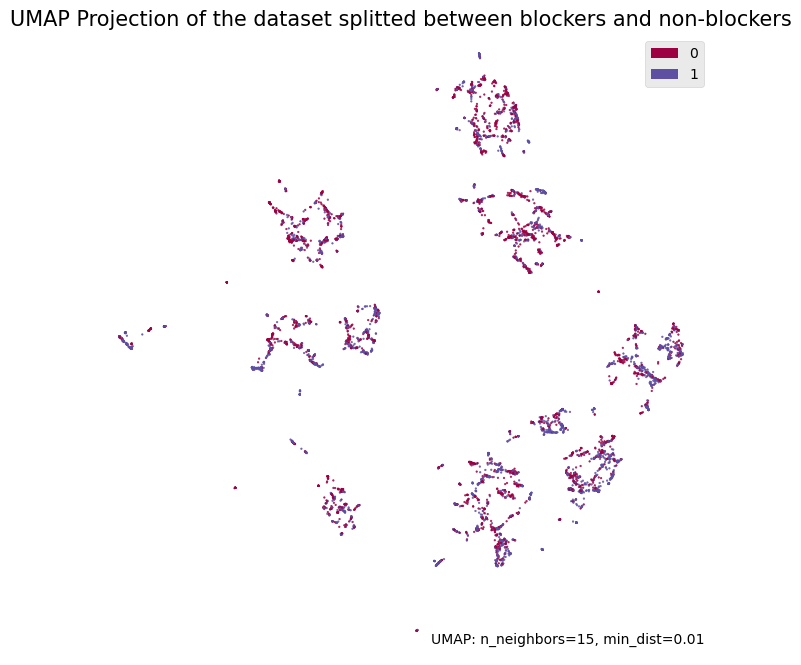

In [452]:
umap.plot.points(reducer, labels=df.Outcome, alpha=0.8)
plt.title('UMAP Projection of the dataset splitted between blockers and non-blockers', fontsize=15)
plt.gca().set_aspect('equal', 'datalim')

The structure obtained from UMAP is an intermediate topological representation and it can be simplified down to a weighted graph. Plotting the connectivity provides at least one basic diagnostic view that helps a user understand what is going on with an embedding. 

Text(0.5, 1.0, 'UMAP Connectivity Projection')

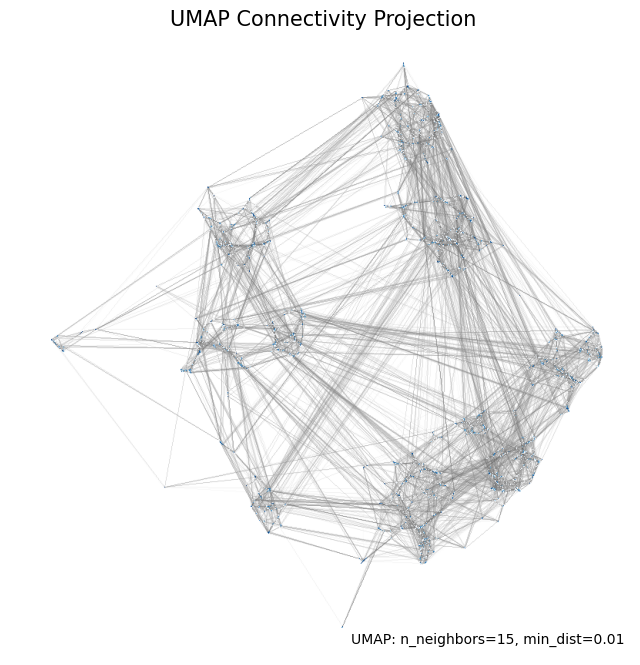

In [453]:

umap.plot.connectivity(reducer, show_points=True)
plt.title('UMAP Connectivity Projection', fontsize=15)

Furthermore, edge-bundling options provides a less busy view of connectivity, but can be expensive to compute. 

In [454]:

#umap.plot.connectivity(reducer, edge_bundling='hammer')
#plt.title('UMAP Connectivity Projection', fontsize=15)

Finally, using **HDBSCAN** (clustering algorithm), we are going to be able to form clusters. 

Text(0.5, 1.0, 'Graph showing the original dispersion of the dataset')

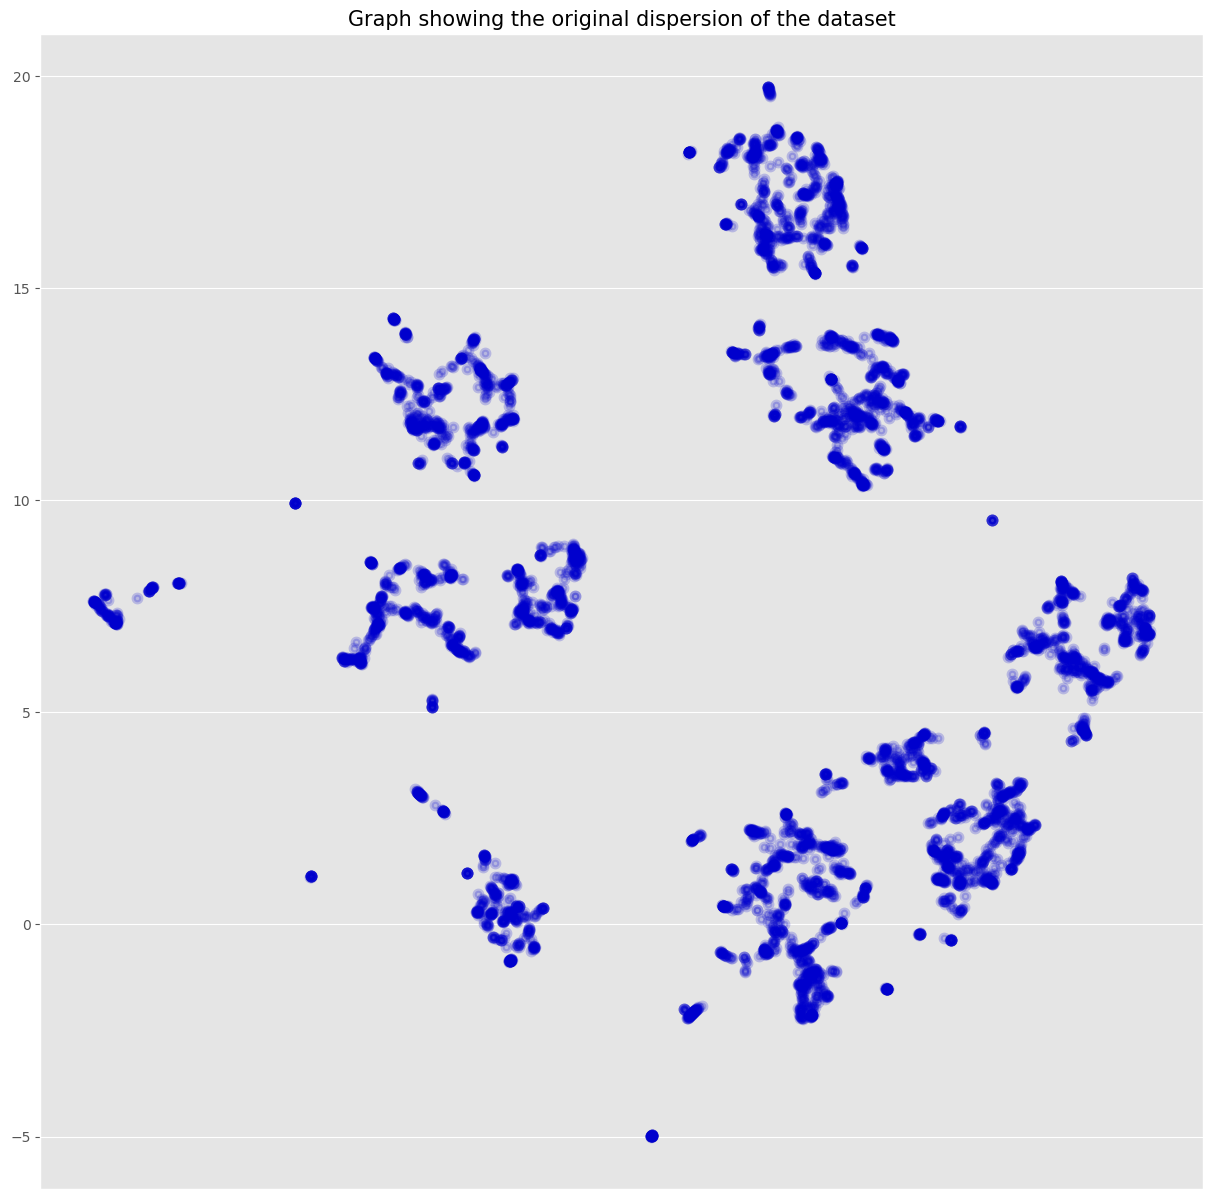

In [455]:
f, ax = plt.subplots(figsize=(15,15))
plt.scatter(embedding.T[0], embedding.T[1], c='mediumblue', **plot_kwds)      # to plot the clustering data set

frame = plt.gca()                                                             # to remove values on the y axe
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(True)

plt.title('Graph showing the original dispersion of the dataset', fontsize=15)

This technique is mostly based on single linkage clustering.

**1. Transform the space according to the density/sparsity.**

To find clusters we want to find the islands of higher density to distinguish them better from the noise. Indeed, a single noise data point can act as a bridge between islands, gluing them together. Therefore, we are aiming at making the core clustering more robust to noise. For that, we estimate the density by calculating the simplest distance to the k nearest neighbor also called 'core distance'. Further, a 'mutual reachability distance' between two centers of radius of defined core distance is found out. Finally, we can compare the mutual reachability distance to approximate the true density distribution. 

**2. Build the minimum spanning tree of the distance weighted graph.**

Now that we have a new mutual reachability metric on the data we want start finding the islands on dense data. We will consider the data as a weighted graph. The weight will be equal to the mutaul reachability distance of thoses points. Next, a descending threshold value will be applied in order to disconnect the graph into connected components.For that, the minimum spanning tree of the graph allows to build one edge at a time by adding the lowest weight edge. 

In [816]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=160, gen_min_span_tree=True)       # to cluster the data 
clusterer.fit(embedding)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=160)

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


Text(0.5, 1.0, 'Histogram presenting the size of the clusters')

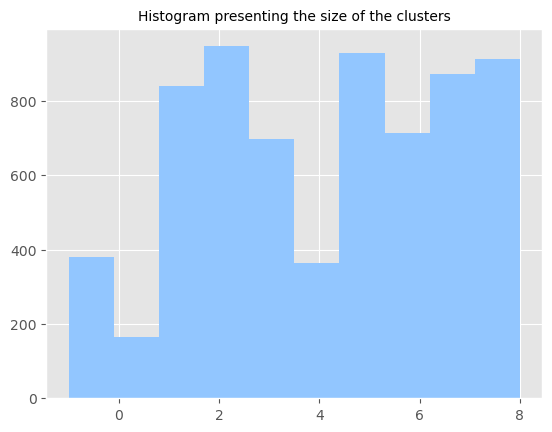

In [817]:
plt.hist(clusterer.labels_)
print(set(clusterer.labels_))
N = len(set(clusterer.labels_))

plt.title('Histogram presenting the size of the clusters', fontsize=10)

Text(0.5, 1.0, 'Minimum spanning tree for mutual reachability distance')

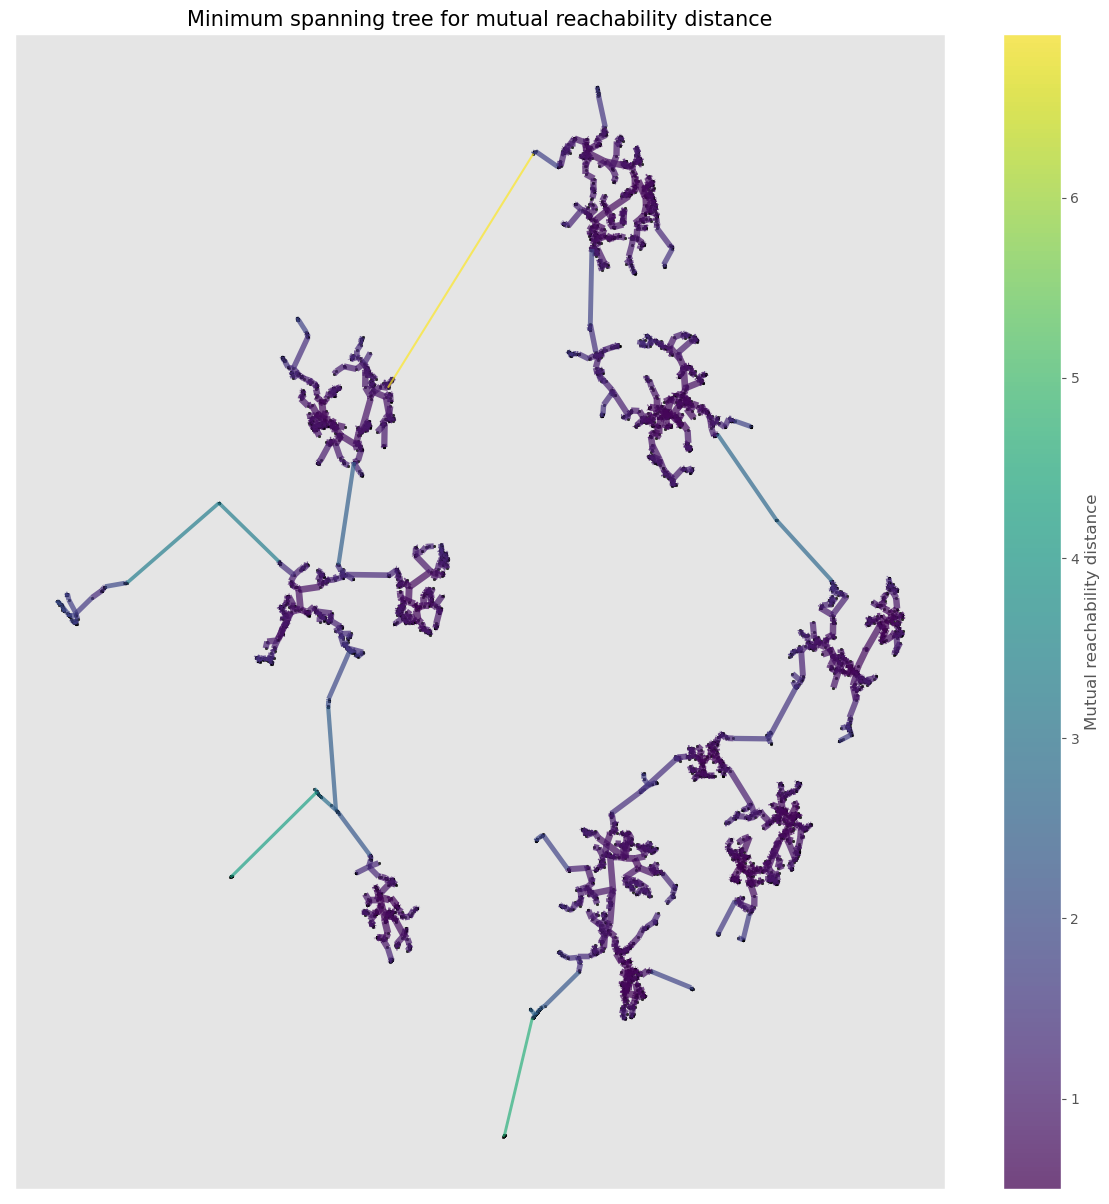

In [818]:
f, ax = plt.subplots(figsize=(15,15))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.7,
                                      node_size=3,
                                      edge_linewidth=1.5)
plt.title('Minimum spanning tree for mutual reachability distance', fontsize=15)

**3. Construct a cluster hierarchy of connected components.**

Given the minimal spanning tree, the next step is to convert that into the hierarchy of connected components. The edges of the tree will be sorted in increasing order by distance. At each edge a merged cluster will be created after iterating. Via a union-find data structure, we will join two clusters at each edge. It stores a partition of a set into disjoint subsets. It provides operations for adding new sets, merging sets (replacing them by their union), and finding a representative member of a set. The last operation makes it possible to find out efficiently if any two elements are in the same or different sets.

The results can be viewed in the following dendrogram : 

Text(0.5, 1.0, 'Dendogram representing the cluster hierarchy of connected components')

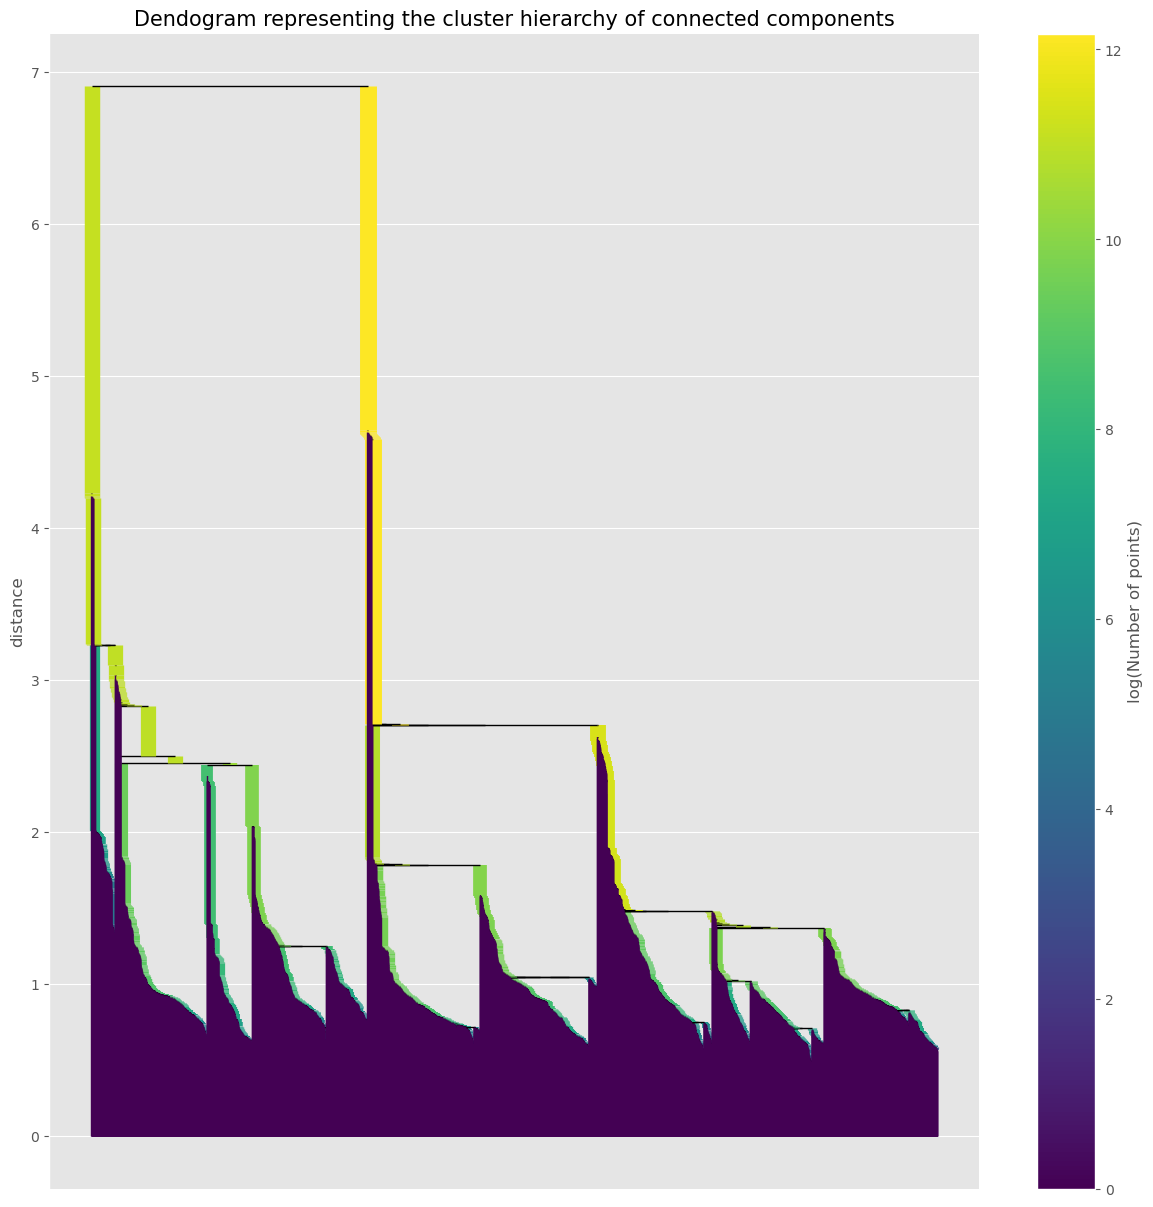

In [819]:
# Density Cluster Tree

plt.style.use('seaborn-pastel')
f, ax = plt.subplots(figsize=(15,15))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.title('Dendogram representing the cluster hierarchy of connected components', fontsize=15)    

As shown on the dendogram, any single linkage was eliminated. Given that hierarchy, the next step is to define set of flat clusters. This is most easily done with DBSCAN (declaring any singleton clusters at the cut level as noise). The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. 


**4. Condense the cluster hierarchy based on minimum cluster size.**

In order to extract the clusters, we need first to condense down the large and complicated cluster hierarchy into a smaller tree. 

As you can see in the hierarchy above it is often the case that a cluster split is one or two points splitting off from a cluster; and that is the key point – rather than seeing it as a cluster splitting into two new clusters we want to view it as a single persistent cluster that is ‘losing points’.

From the root, we walk through the hierarchy and see if each clusters is smaller as the minimum clustersize. If it the case, then this split is removed from the tree. 

Similar to the dendogram above, we can visualize the smaller tree : 

Text(0.5, 1.0, 'Dendogram representing the condensed cluster hierarchy')

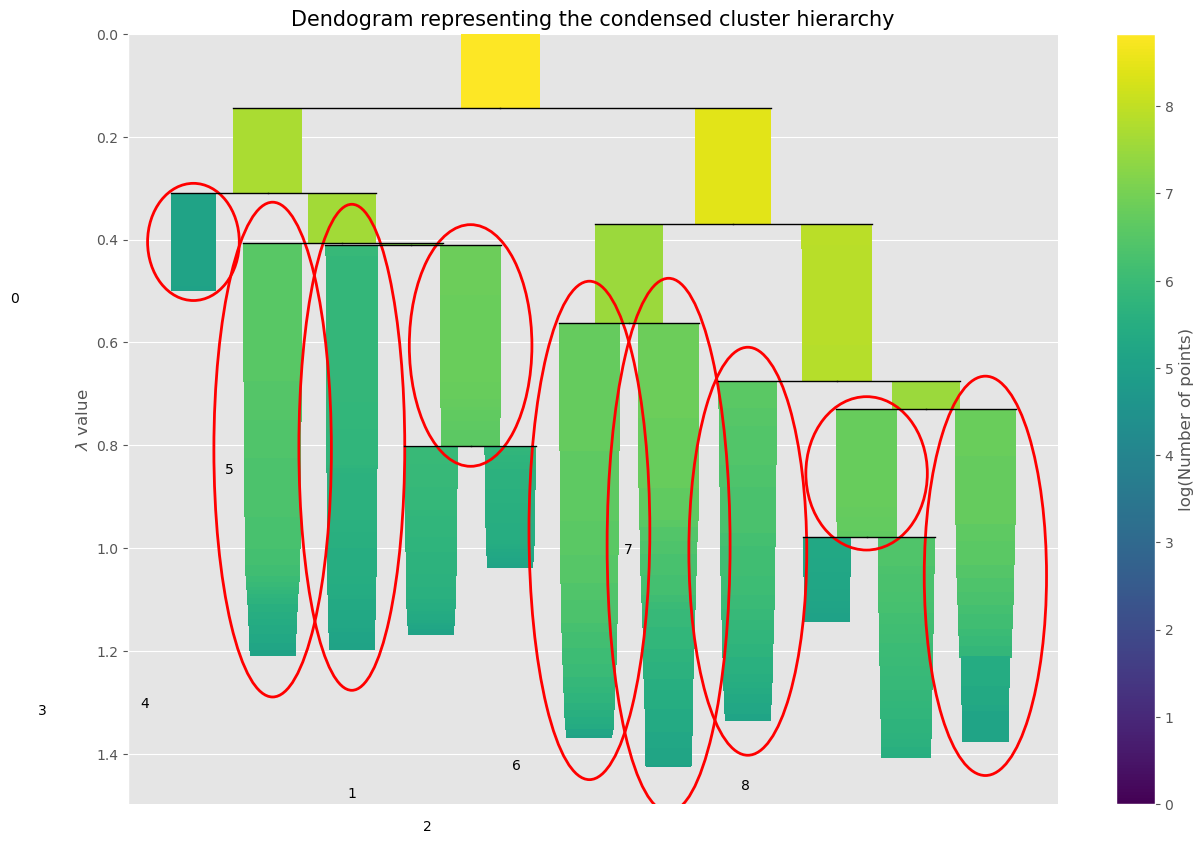

In [820]:
f, ax = plt.subplots(figsize=(15,10))
clusterer.condensed_tree_.plot(leaf_separation=1, cmap='viridis', select_clusters=True,
             label_clusters=True, selection_palette=None,
             axis=None, colorbar=True, log_size=True,
             max_rectangles_per_icicle=20)
plt.title('Dendogram representing the condensed cluster hierarchy', fontsize=15)


Text(0.5, 1.0, 'Dendogram representing the condensed cluster hierarchy')

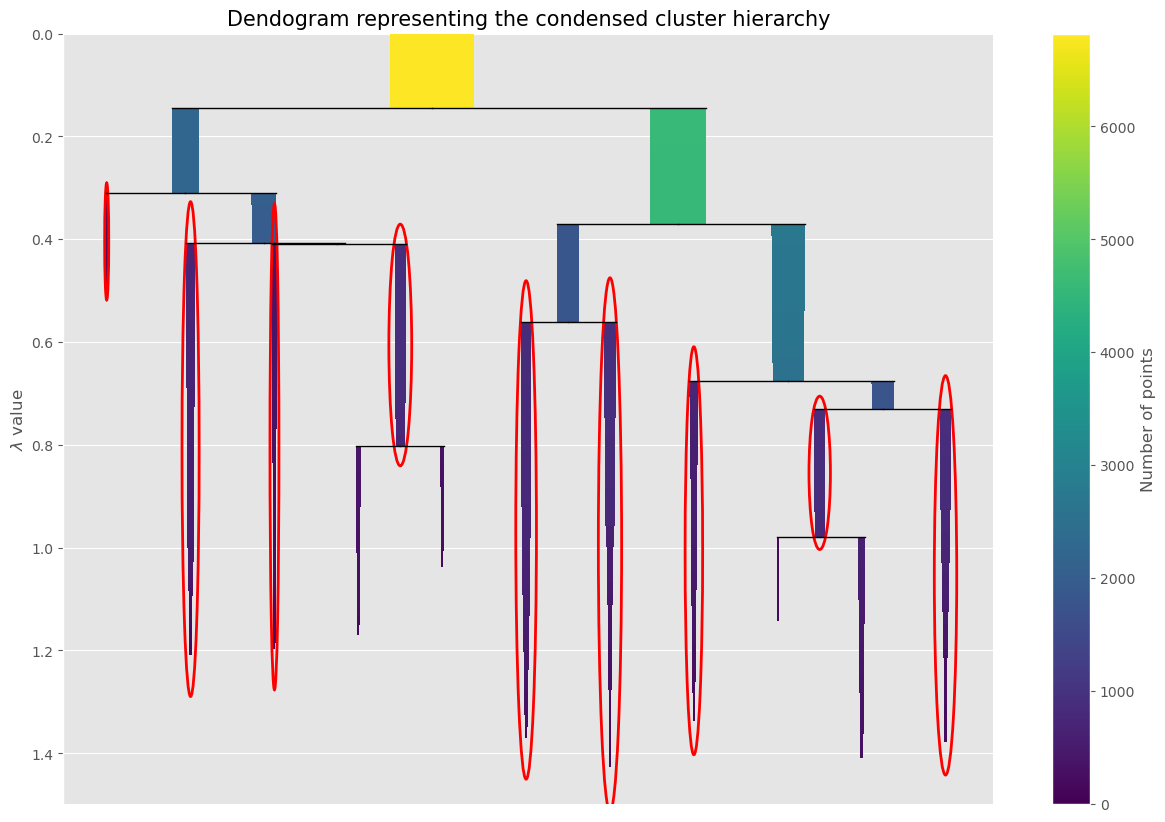

In [821]:
f, ax = plt.subplots(figsize=(15,10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title('Dendogram representing the condensed cluster hierarchy', fontsize=15)

**5. Extract the stable clusters from the condensed tree.**

Using Pyplot Package : 

In [822]:
fig = px.scatter(x=data.T[descr_dict['ExactMolWt']], y=data.T[descr_dict['qed']], color=clusterer.labels_, title= 'Graph showing the dispersion of the molecular weight')
fig.show()
fig.write_html('test.html')

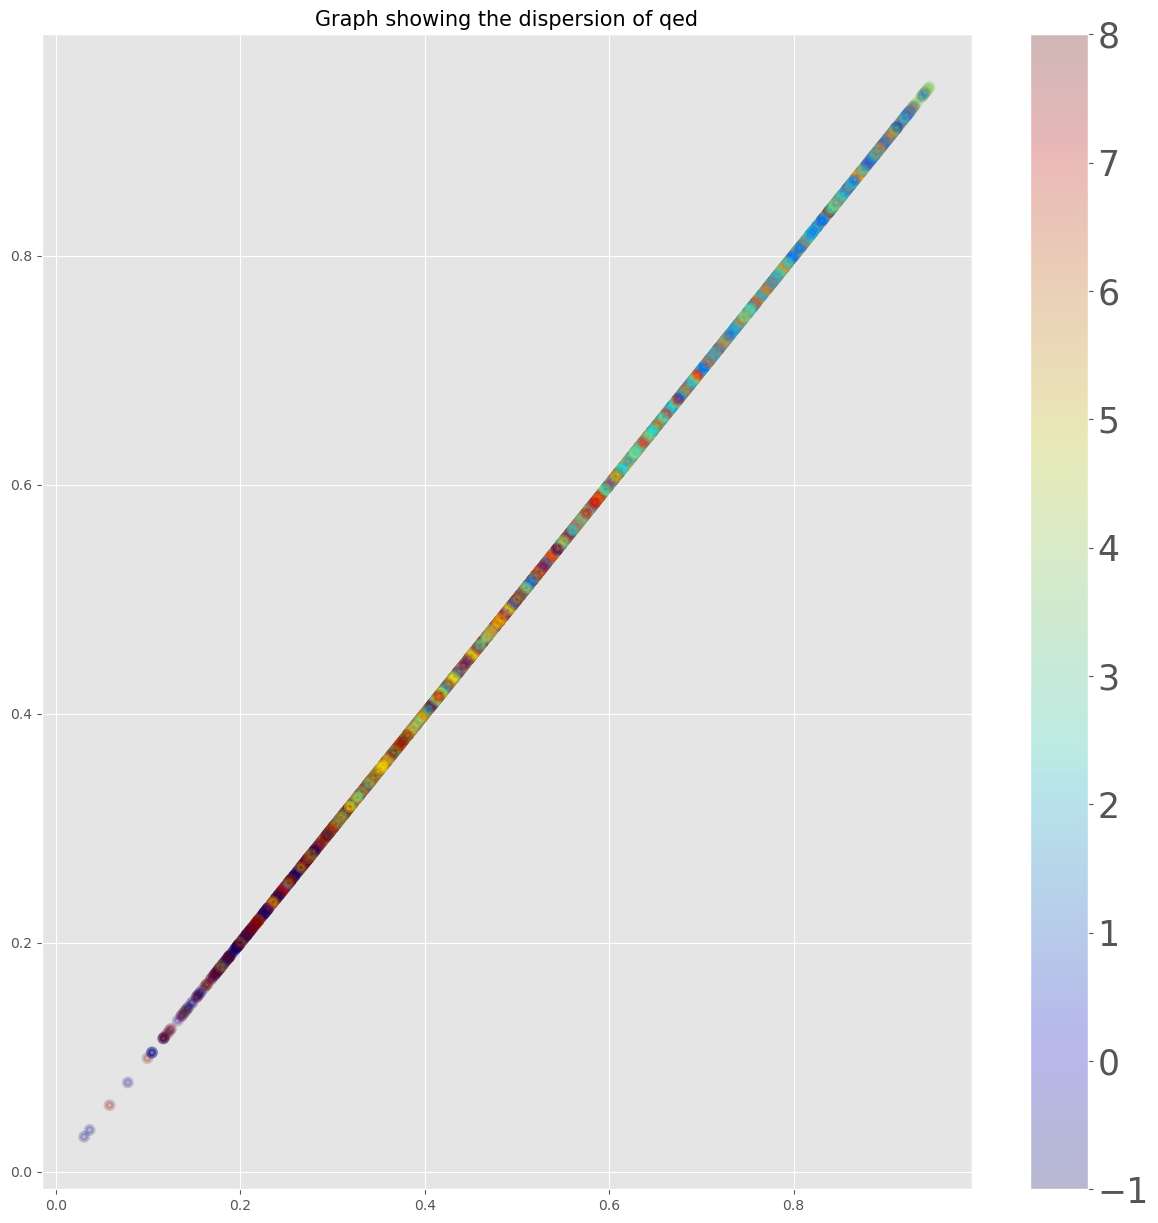

In [823]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

f, ax = plt.subplots(figsize=(15,15))
points = plt.scatter(data.T[descr_dict['qed']], data.T[descr_dict['qed']], c=clusterer.labels_, cmap=cmap, **plot_kwds)

frame = plt.gca()                                          # to remove values on the y axe
frame.axes.get_xaxis().set_visible(True)
frame.axes.get_yaxis().set_visible(True)

plt.title('Graph showing the dispersion of qed', fontsize=15)
cbar = f.colorbar(points)
cbar.ax.tick_params(labelsize=25) 

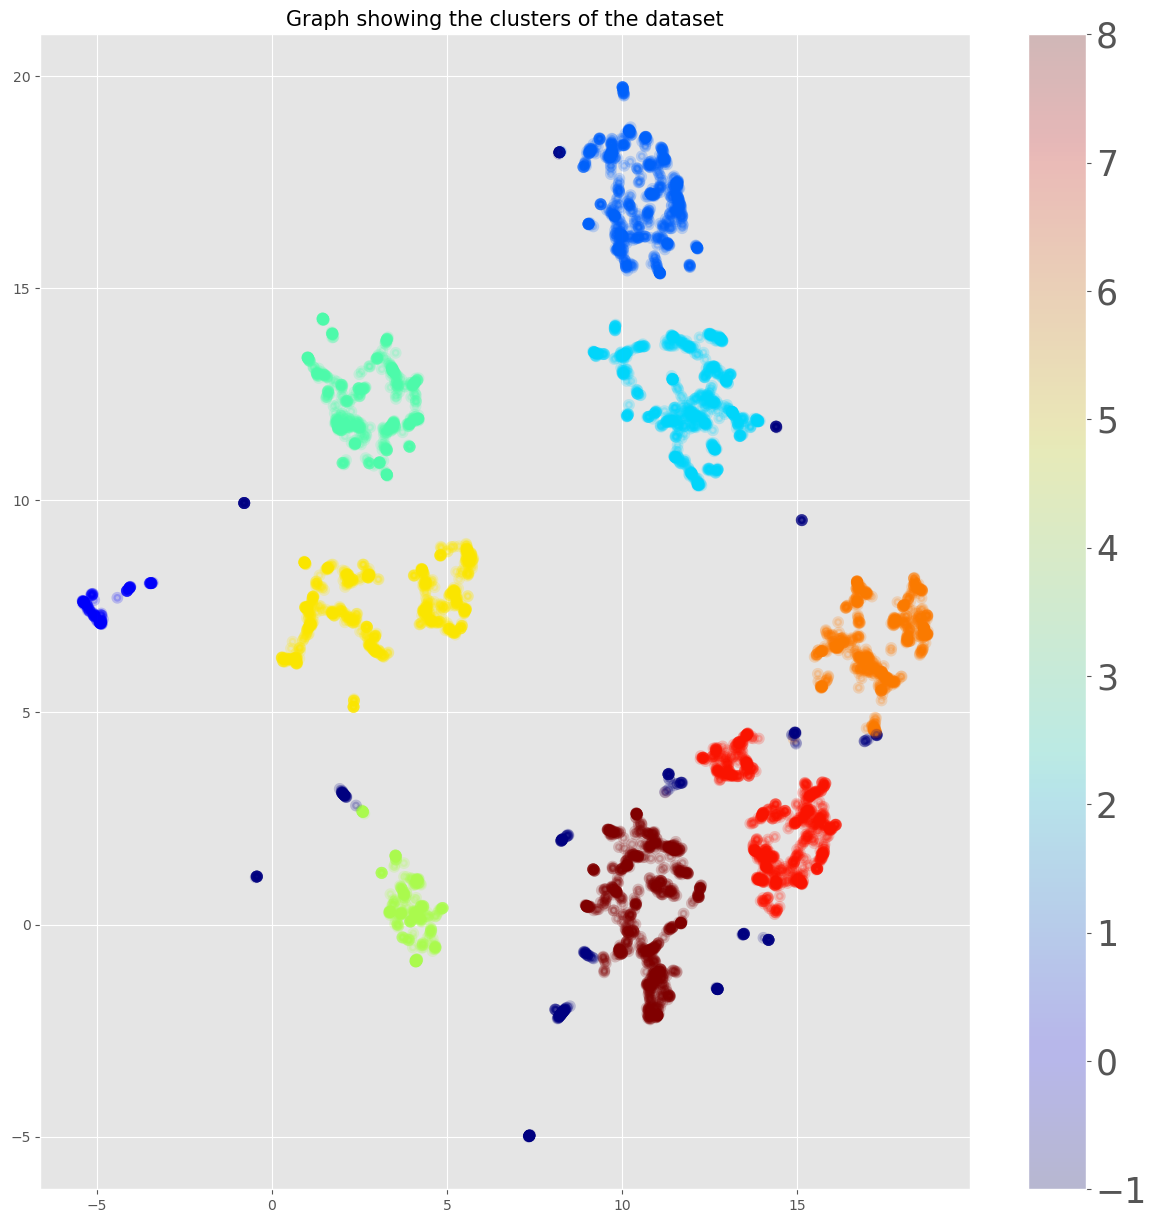

In [824]:
plot_kwds = {'alpha' : 0.2, 's' : 30, 'linewidths':3}   

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

f, ax = plt.subplots(figsize=(15,15))
points = plt.scatter(embedding.T[0], embedding.T[1], c=clusterer.labels_, cmap=cmap, **plot_kwds)

frame = plt.gca()                                          # to remove values on the y axe
frame.axes.get_xaxis().set_visible(True)
frame.axes.get_yaxis().set_visible(True)

plt.title('Graph showing the clusters of the dataset', fontsize=15)
cbar = f.colorbar(points)
cbar.ax.tick_params(labelsize=25) 

To conclude, HDBSCAN has allowed to cluster the data.

In [825]:
clusterer.labels_  # an array of integer for each data sample ; samples from the same clusters get the same number assigned 

array([ 1, -1,  2, ...,  6,  1,  5])

In [826]:
clusterer.labels_.max()  # to determine the number of clusters by finding the largest cluster label

8

So we have a total of 10 clusters, with label 0 and -1 in addition. 

Importantly HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. This is handled by assigning these samples the label -1. 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Part 3: Creation of a validation set**

**Step 1 : Extraction of the test set from hdbscan by identifying the clusters**

In [827]:
clusters_dict = {x:[] for x in set(clusterer.labels_)}   # to create a dictionary counting the iterations using the enumerate function which allow us to identify to which cluster a sample belongs 
for i, cluster in enumerate(clusterer.labels_):
    clusters_dict[cluster].append(i)

In [828]:
clusters_dict

{0: [160,
  230,
  231,
  237,
  275,
  287,
  306,
  366,
  380,
  420,
  431,
  594,
  625,
  769,
  774,
  831,
  893,
  900,
  920,
  988,
  1054,
  1081,
  1092,
  1145,
  1171,
  1200,
  1250,
  1297,
  1303,
  1349,
  1385,
  1436,
  1438,
  1494,
  1499,
  1521,
  1629,
  1655,
  1663,
  1681,
  1691,
  1739,
  1757,
  1910,
  1965,
  2095,
  2099,
  2116,
  2187,
  2191,
  2202,
  2206,
  2213,
  2234,
  2281,
  2288,
  2314,
  2328,
  2329,
  2332,
  2347,
  2361,
  2363,
  2366,
  2389,
  2420,
  2443,
  2463,
  2515,
  2566,
  2596,
  2617,
  2680,
  2715,
  2817,
  2863,
  2881,
  2941,
  2958,
  2959,
  2986,
  3056,
  3103,
  3110,
  3152,
  3303,
  3357,
  3403,
  3468,
  3505,
  3567,
  3688,
  3694,
  3709,
  3728,
  3735,
  3746,
  3769,
  3791,
  3796,
  3857,
  3911,
  3934,
  4079,
  4090,
  4094,
  4120,
  4135,
  4211,
  4292,
  4351,
  4393,
  4529,
  4560,
  4615,
  4651,
  4746,
  4823,
  4858,
  4937,
  4966,
  5087,
  5110,
  5136,
  5163,
  5164,
  5170,
 

**Step 2 : Add a column 'Clusters' in the Panda Dataframe**

From HDBSCAN, we have associated each sample to a cluster. 

In [829]:
df['Clusters'] = clusterer.labels_.tolist()
df

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",PICKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,CCCOCCn1c(=O)c(N2CCN(C(C)C(C)O)CC2)nc2cnc(-c3c...,496.279804,0.422826,1.861111,105.84,10.0,1.0,2.18000,0.538462,10.0,...,1,7.267606,ZZHCAPMRVHYZMC-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",6819
6820,NC(=O)c1cnc(NC2CNCCC2O)c2cc(-c3ccccc3)sc12,368.130697,0.565644,2.153846,100.27,6.0,4.0,2.19690,0.263158,4.0,...,0,NaN,ZZJBCGMTQHRATH-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6821,CC(=O)C1=NN2c3cc(F)ccc3OCC2C1(CCCN(C)C)c1ccccc1,395.200905,0.749341,2.034483,45.14,5.0,0.0,3.63150,0.391304,6.0,...,1,5.226214,ZZLRBKFHORVSEX-UHFFFAOYNA-N,False,False,False,NaN,6,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6822,O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(O)cc(Cl)c12,334.108420,0.846122,2.000000,65.56,4.0,2.0,3.16960,0.470588,3.0,...,0,NaN,ZZNMCYCBKMJHPV-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS


 **Step 3 : Diversity Selection** 
 
 After identifying the clusters, we are going to select randomly 150 points out of each cluster by using the MaxMin algorithm by generating Morgan Fingerprint. 

 Indeed, Max-Min clustering is preferable to a density-based clustering algorithm which tend to select many samples from the dense group.

In [830]:
for i in set(df.SMILES_new):                   # to construct a molecule from a SMILES string
    mol = Chem.MolFromSmiles(i)

We start by generating Morgan2 fingerprints for the diversity calculation. 

In [831]:
fps = []                                                             # array where fingerprints are stired at each iteration
for i in set(df.SMILES_new):                                         # for loop that transform each molecule :  SMILES ->  Structural Contruction -> Morgan2 fingerprints
    mol = Chem.MolFromSmiles(i) 
    if mol is None:
        continue
    fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,2)         # to obtain the fingerprint of mol
    fps.append(fp)                                                   # to add the fingerprint of mol into the fingerprints array 
    if not len(fps)%5000: print("Done: %d"%len(fps))                 # to print the results

print("Got %d fingerprints"%len(fps))    

Done: 5000
Got 6824 fingerprints


In [832]:
df['fingerprint'] = fps  # to add a fingerprint column in the dataframe
df

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",PICKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,CCCOCCn1c(=O)c(N2CCN(C(C)C(C)O)CC2)nc2cnc(-c3c...,496.279804,0.422826,1.861111,105.84,10.0,1.0,2.18000,0.538462,10.0,...,1,7.267606,ZZHCAPMRVHYZMC-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",6819
6820,NC(=O)c1cnc(NC2CNCCC2O)c2cc(-c3ccccc3)sc12,368.130697,0.565644,2.153846,100.27,6.0,4.0,2.19690,0.263158,4.0,...,0,NaN,ZZJBCGMTQHRATH-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6821,CC(=O)C1=NN2c3cc(F)ccc3OCC2C1(CCCN(C)C)c1ccccc1,395.200905,0.749341,2.034483,45.14,5.0,0.0,3.63150,0.391304,6.0,...,1,5.226214,ZZLRBKFHORVSEX-UHFFFAOYNA-N,False,False,False,NaN,6,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6822,O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(O)cc(Cl)c12,334.108420,0.846122,2.000000,65.56,4.0,2.0,3.16960,0.470588,3.0,...,0,NaN,ZZNMCYCBKMJHPV-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS


In [833]:
fps_cluster_count = df.groupby('Clusters').count().reset_index()[['Clusters','fingerprint']]  # to count the number of fingerprints generated per cluster
fps_cluster_count

,Clusters,fingerprint
0,-1,381
1,0,166
2,1,841
3,2,947
4,3,698
5,4,365
6,5,929
7,6,713
8,7,872
9,8,912


In [834]:
cluster_to_pool = fps_cluster_count.Clusters[fps_cluster_count.fingerprint < 250].to_list()      # to identify clusters below 250 and add them in a list named cluster_to_pool
cluster_to_pool

[0]

In [835]:
df.Clusters = [-1 if i in cluster_to_pool else i for i in df.Clusters] # to add the clusters below 250 (= cluster_to_pool) to the cluster -1 considered as 'noise cluster'


In [836]:
df[df.Clusters.isin(cluster_to_pool)] # to check that the clusters below 250 (= cluster_to_pool) are not anymore present in the dataframe

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID


In [837]:
df[df.Clusters == -1] # to check if the cluster -1 has now the samples from the clusters below 250 (=cluster_to_pool)

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
34,O=C(CC1CCN(Cc2ccn(-c3ccc(C(F)(F)F)cc3)c2)CC1)N...,600.191517,0.227386,1.714286,70.13,4.0,2.0,6.48480,0.290323,8.0,...,0,NaN,ACHAGBFZZOHGJZ-UHFFFAOYNA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",34
36,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C)oc6c(C)c5CC4...,512.235831,0.214048,1.837838,72.87,8.0,0.0,5.67976,0.379310,6.0,...,1,5.300000,ACRMNEFOWLXFLY-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36
70,Cn1cc(C2(c3nc(=O)o[nH]3)NC(c3nc(-c4ccc(F)cn4)c...,497.172399,0.292870,2.027027,146.10,8.0,4.0,2.68080,0.160000,4.0,...,1,5.920819,AFHKVSNSPKNANW-UHFFFAOYNA-N,False,False,False,NaN,-1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",70
87,c1ccc(CN2CCN(Cc3nc(-c4ccccc4)no3)CC2)cc1,334.179361,0.717491,1.360000,45.40,5.0,0.0,3.05440,0.300000,5.0,...,0,4.896196,AGMZWJCXRAGFQR-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6736,O=C(O)CCc1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc...,544.341341,0.311996,1.575000,69.14,6.0,1.0,5.26160,0.515152,12.0,...,0,4.500000,ZQVGMOFPWWNMNB-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6752,CC1c2nnc(-c3csc(-c4ccc(F)cc4F)n3)n2CCN1C(=O)c1...,519.099909,0.279887,1.861111,63.91,7.0,0.0,6.29230,0.153846,4.0,...,1,5.853872,ZSIQAOCNFRWDNJ-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6783,O=c1ccc2ncc(F)c3c2n1CC3(O)CC12CCC(NCc3cc4c(nn3...,495.191797,0.543245,1.972222,120.62,10.0,2.0,1.55970,0.520000,5.0,...,0,NaN,ZWGPKBUFEJFNDK-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6788,Cc1nccn1CC(NC(=O)NC1CCN(Cc2ccn(-c3ccc(C(F)(F)F...,550.266794,0.295615,1.750000,67.12,5.0,2.0,5.70612,0.333333,8.0,...,0,NaN,ZWLGQCPYBKFAIX-UHFFFAOYNA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6788


In [838]:
picks_out_clusters = {}                                    # dictionary containing the indice of the picks found by the MaxMinPicker by cluster

for i in set(df.Clusters):
    cluster_df = df[df.Clusters == i].reset_index()
    fps_list = cluster_df.fingerprint.to_list()                               # necessary condition to make the diversity selection within each cluster
    print(f'cluster{i} - {len(fps_list)}')                 # to print each cluster with his lenght
    picker =SimDivFilters.MaxMinPicker()                   # to create a class for diversity picking items using the MaxMin Algorithm
    picks = picker.LazyBitVectorPick(fps_list,len(fps_list),200)     # to pick a subset of items from a collection of bit verctors using Tanimoto distance  -> diversity selection
    picks = [cluster_df['index'][i] for i in picks]


    picks_out_clusters[i] = []
    picks_out_clusters[i].append(list(picks))              # to add picks per cluster in a dictionary 


    print(f'cluster{i} - picksIndices: {list(picks)}', len(picks)) 

cluster1 - 841
cluster1 - picksIndices: [2357, 3324, 1582, 4586, 3686, 6771, 2393, 1646, 6584, 1897, 4072, 4668, 3355, 4716, 3981, 2086, 3711, 4064, 4249, 4431, 6147, 2472, 6481, 3962, 3312, 3636, 4325, 4208, 2853, 4736, 5934, 1827, 2210, 6026, 4843, 4535, 2078, 5269, 6748, 3793, 3354, 1874, 323, 3808, 4863, 1455, 2358, 3162, 2487, 5631, 2493, 6519, 4523, 2747, 3260, 177, 4574, 6113, 1176, 5555, 3356, 6339, 987, 5699, 1216, 4139, 5753, 6678, 200, 2497, 47, 174, 805, 2697, 3057, 3302, 4380, 4981, 1110, 2875, 4705, 5601, 5700, 6247, 4489, 3562, 5606, 5949, 5460, 4332, 1718, 3221, 6302, 3273, 187, 536, 88, 5847, 6318, 1572, 1622, 2650, 3866, 2097, 4562, 509, 828, 3939, 133, 1610, 6755, 4061, 4396, 3254, 2308, 3554, 2057, 1517, 924, 2212, 354, 4054, 2473, 4926, 817, 3015, 1162, 887, 958, 5456, 1155, 6044, 748, 2644, 5067, 3328, 3585, 560, 3588, 4824, 5879, 1434, 6300, 5287, 3814, 446, 522, 3119, 5738, 2974, 5490, 6686, 5637, 1851, 350, 3593, 2397, 4401, 1184, 3235, 1305, 1251, 2763, 3297, 

In [839]:
fps_list

Text(0.5, 1.0, 'MaxMin Picks')

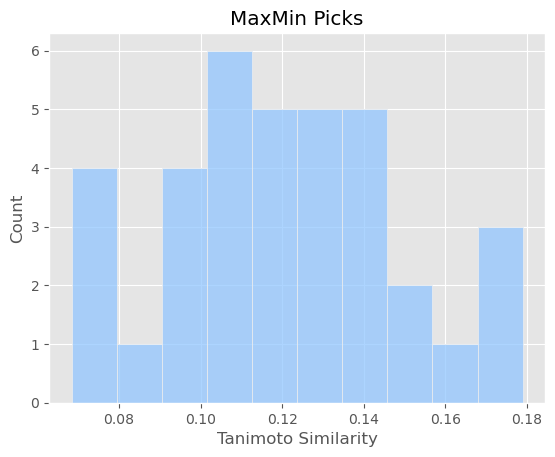

In [840]:
dist_hist=[]                                                                                  # to create an histogram representing the similarity, based on tanimoto similarity between the fingerprints of the molecules of the dataset
for i in range(len(picks_out_clusters)):
    for j in range(i+1,len(picks_out_clusters)):
        fps_cluster = [df.fingerprint.to_list()[i] for i in picks_out_clusters]
        fps_i = fps_cluster[i]
        fps_j = fps_cluster[j] 
        dist_hist.append(DataStructs.TanimotoSimilarity(fps_i, fps_j))

df_Tanimoto = pd.DataFrame(dist_hist, columns= ['Tanimoto Similarity'])
sns.histplot(data = df_Tanimoto, x = 'Tanimoto Similarity', bins = 10)  
plt.title("MaxMin Picks")

In [841]:
#dist_hist=[]                                                                                  # to create an histogram representing the similarity, based on tanimoto similarity between the fingerprints of the molecules of the dataset
#for i in range(len(picks_out_clusters[1][0])):
    #for j in range(i+1,len(picks_out_clusters[1][0])):
        #fps_cluster = [df.fingerprint.to_list()[i] for i in picks_out_clusters[1][0]]
        #fps_i = fps_cluster[i]
        #fps_j = fps_cluster[j] 
        #dist_hist.append(DataStructs.TanimotoSimilarity(fps_i, fps_j))

#df_Tanimoto = pd.DataFrame(dist_hist, columns= ['Tanimoto Similarity'])
#sns.histplot(data = df_Tanimoto, x = 'Tanimoto Similarity')  
#plt.title("MaxMin Picks")

**Step 4 : Creation of the Validation dataset (only composed of the picks)**

In [842]:
test_ids = []

for value in picks_out_clusters.keys():          # remove the keys in the dictionnary picks_out_clusters and use the estend() method to add all the values into a list named test_ids using 
    l = picks_out_clusters[value]
    test_ids.extend(l)


In [845]:
flat_ids = []                                    # to flatten the list of test_ids using nested for loops ; the elements are added into the list named flat_ids

for element in test_ids:
    if type(element) is list:
        for item in element:
            flat_ids.append(item)
    else:
        flat_ids.append(element)

flat_ids

[2357,
 3324,
 1582,
 4586,
 3686,
 6771,
 2393,
 1646,
 6584,
 1897,
 4072,
 4668,
 3355,
 4716,
 3981,
 2086,
 3711,
 4064,
 4249,
 4431,
 6147,
 2472,
 6481,
 3962,
 3312,
 3636,
 4325,
 4208,
 2853,
 4736,
 5934,
 1827,
 2210,
 6026,
 4843,
 4535,
 2078,
 5269,
 6748,
 3793,
 3354,
 1874,
 323,
 3808,
 4863,
 1455,
 2358,
 3162,
 2487,
 5631,
 2493,
 6519,
 4523,
 2747,
 3260,
 177,
 4574,
 6113,
 1176,
 5555,
 3356,
 6339,
 987,
 5699,
 1216,
 4139,
 5753,
 6678,
 200,
 2497,
 47,
 174,
 805,
 2697,
 3057,
 3302,
 4380,
 4981,
 1110,
 2875,
 4705,
 5601,
 5700,
 6247,
 4489,
 3562,
 5606,
 5949,
 5460,
 4332,
 1718,
 3221,
 6302,
 3273,
 187,
 536,
 88,
 5847,
 6318,
 1572,
 1622,
 2650,
 3866,
 2097,
 4562,
 509,
 828,
 3939,
 133,
 1610,
 6755,
 4061,
 4396,
 3254,
 2308,
 3554,
 2057,
 1517,
 924,
 2212,
 354,
 4054,
 2473,
 4926,
 817,
 3015,
 1162,
 887,
 958,
 5456,
 1155,
 6044,
 748,
 2644,
 5067,
 3328,
 3585,
 560,
 3588,
 4824,
 5879,
 1434,
 6300,
 5287,
 3814,
 446,
 

In [846]:
len(flat_ids)                                         # to verify that the list flat_ids contains all the picks 

1800

In [847]:
id = [*range(0,len(df))]                               # to create a column containing the identifiant of each sample which corresponds to the index of the sample in the dataframe
df['ID'] = id
df

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,CCCOCCn1c(=O)c(N2CCN(C(C)C(C)O)CC2)nc2cnc(-c3c...,496.279804,0.422826,1.861111,105.84,10.0,1.0,2.18000,0.538462,10.0,...,1,7.267606,ZZHCAPMRVHYZMC-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",6819
6820,NC(=O)c1cnc(NC2CNCCC2O)c2cc(-c3ccccc3)sc12,368.130697,0.565644,2.153846,100.27,6.0,4.0,2.19690,0.263158,4.0,...,0,NaN,ZZJBCGMTQHRATH-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6820
6821,CC(=O)C1=NN2c3cc(F)ccc3OCC2C1(CCCN(C)C)c1ccccc1,395.200905,0.749341,2.034483,45.14,5.0,0.0,3.63150,0.391304,6.0,...,1,5.226214,ZZLRBKFHORVSEX-UHFFFAOYNA-N,False,False,False,NaN,6,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6821
6822,O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(O)cc(Cl)c12,334.108420,0.846122,2.000000,65.56,4.0,2.0,3.16960,0.470588,3.0,...,0,NaN,ZZNMCYCBKMJHPV-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",6822


In [848]:
df.loc[df.ID.isin(flat_ids), 'ID'] = 'PICKS'           # to replace the identifiant of the molecules that were picked during the diversity selection
df

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",PICKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,CCCOCCn1c(=O)c(N2CCN(C(C)C(C)O)CC2)nc2cnc(-c3c...,496.279804,0.422826,1.861111,105.84,10.0,1.0,2.18000,0.538462,10.0,...,1,7.267606,ZZHCAPMRVHYZMC-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",6819
6820,NC(=O)c1cnc(NC2CNCCC2O)c2cc(-c3ccccc3)sc12,368.130697,0.565644,2.153846,100.27,6.0,4.0,2.19690,0.263158,4.0,...,0,NaN,ZZJBCGMTQHRATH-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6821,CC(=O)C1=NN2c3cc(F)ccc3OCC2C1(CCCN(C)C)c1ccccc1,395.200905,0.749341,2.034483,45.14,5.0,0.0,3.63150,0.391304,6.0,...,1,5.226214,ZZLRBKFHORVSEX-UHFFFAOYNA-N,False,False,False,NaN,6,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6821
6822,O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(O)cc(Cl)c12,334.108420,0.846122,2.000000,65.56,4.0,2.0,3.16960,0.470588,3.0,...,0,NaN,ZZNMCYCBKMJHPV-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",6822


In [849]:
count_picks_df = []                                   # list based on the condition if a sample is a pick or not 
for i in df.ID : 
    if i == 'PICKS':
        count_picks_df.append(True)
    else :
        count_picks_df.append(False)

In [850]:
count_picks_df.count(True)                             # to count the number of picks in the dataframe

1800

In [851]:
count_picks_df.count(False)                            # to count the number of non-picks sample in the dataframe

5024

In [852]:
NOTPICKS = df[df.ID != 'PICKS'].index                     # to drop the rows of the dataframe that are samples choosen by the diversity selection 
df_validation = df.drop(NOTPICKS)
df_validation

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,6.0,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,8.0,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",PICKS
5,Cc1ncoc1-c1nnc(SCCCN2CCC3(CC3c3ccccc3)C2)n1C,409.193631,0.431725,2.103448,59.98,7.0,0.0,4.14032,0.500000,7.0,...,1,5.420000,AAPXNHMQKBDDJN-UHFFFAOYNA-N,False,False,False,NaN,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",PICKS
6,CN(C)Cc1ccc(C(F)(F)F)cc1Oc1ccc(Cl)c(Cl)c1,363.040454,0.673225,1.695652,12.47,2.0,0.0,5.86610,0.250000,4.0,...,1,5.950782,AAQZZAVVFRIEOD-UHFFFAOYSA-N,False,False,False,NaN,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
10,O=C(Cc1ccc(-n2cnnn2)cc1)N1CCN(CCc2ccc3c(c2)COC...,418.211724,0.605615,1.709677,76.38,7.0,0.0,1.62190,0.391304,6.0,...,1,5.602060,AAYRYIFNKRSGOF-UHFFFAOYSA-N,False,False,False,NaN,7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6800,Cn1ccnc1C(=O)N1CCC(c2ccc(C(=O)NC(=N)N)cc2C(F)(...,422.167809,0.518581,1.933333,117.10,5.0,3.0,2.08197,0.368421,3.0,...,0,NaN,ZXZKBUDCPJISJW-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6804,O=C(Nc1c(Cl)cncc1Cl)c1cn(-c2ccc(Cl)cc2)c2ncccc...,443.994759,0.481650,1.689655,76.88,5.0,1.0,4.99320,0.000000,3.0,...,1,6.703335,ZYQHRABKRQWTBJ-UHFFFAOYSA-N,False,False,False,NaN,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6812,C=CC(=O)Nc1cc(Nc2ncc(C#N)c(-c3cn(C)c4ccccc34)n...,524.264822,0.294138,1.974359,111.34,9.0,2.0,4.38148,0.241379,10.0,...,1,5.366532,ZYZAJOCFJDOSLF-UHFFFAOYSA-N,False,False,False,NaN,8,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS
6820,NC(=O)c1cnc(NC2CNCCC2O)c2cc(-c3ccccc3)sc12,368.130697,0.565644,2.153846,100.27,6.0,4.0,2.19690,0.263158,4.0,...,0,NaN,ZZJBCGMTQHRATH-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",PICKS


In [853]:
df_validation.to_csv('Dataframe with picks.csv')                    # to save the dataframe that were picked during the diversity selection

**Step 5 : Creation of the Training dataset (without picks)**

In [854]:
PICKS = df[df.ID == 'PICKS'].index                     # to drop the rows of the dataframe that are samples choosen by the diversity selection 
df_training = df.drop(PICKS)
df_training

,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,5.0,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,6.0,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",1
3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,6.0,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
7,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...,582.230077,0.293449,1.642857,78.26,8.0,1.0,5.24050,0.333333,6.0,...,0,NaN,AATCBLYHOUOCTO-UHFFFAOYSA-N,False,False,False,NaN,8,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
8,CCCN1C(=O)CC2(CCN(CC3CCN(C(=O)OCC)CC3)CC2)c2cc...,428.278741,0.718882,1.935484,65.98,5.0,0.0,3.43040,0.708333,5.0,...,1,6.173925,AATNRUXRJQIOEV-UHFFFAOYSA-N,False,False,False,NaN,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6817,N#CC1(NC(=O)C2CCCCC2C(=O)N2CCN(c3nc4ccccc4s3)C...,437.188546,0.794428,1.806452,89.33,6.0,1.0,2.92368,0.565217,4.0,...,1,5.100000,ZZFJAPGUVYMXSJ-UHFFFAOYSA-N,False,False,False,NaN,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6817
6818,COc1ccc(C2CCC(N3CC(NC(=O)CNc4noc5ccc(C(F)(F)F)...,503.214424,0.499601,1.944444,92.52,7.0,2.0,4.18890,0.480000,7.0,...,1,8.060481,ZZFKFTVPUSBMNB-UHFFFAOYSA-N,False,False,False,NaN,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6818
6819,CCCOCCn1c(=O)c(N2CCN(C(C)C(C)O)CC2)nc2cnc(-c3c...,496.279804,0.422826,1.861111,105.84,10.0,1.0,2.18000,0.538462,10.0,...,1,7.267606,ZZHCAPMRVHYZMC-UHFFFAOYSA-N,False,False,False,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",6819
6821,CC(=O)C1=NN2c3cc(F)ccc3OCC2C1(CCCN(C)C)c1ccccc1,395.200905,0.749341,2.034483,45.14,5.0,0.0,3.63150,0.391304,6.0,...,1,5.226214,ZZLRBKFHORVSEX-UHFFFAOYNA-N,False,False,False,NaN,6,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6821


In [855]:
df_training.to_csv('Dataframe without picks.csv')                    # to save the dataframe that were picked during the diversity selection

**Step 4: Cross-Validation based on the new dataframe -> Training files**

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------